---
### LIBS

In [1]:
# Installation des packages
#!pip install pandas numpy matplotlib statsmodels

In [2]:
# Importation des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.regression.rolling import RollingOLS   
import statsmodels.api as sm

---
### Chargement des données

In [3]:
df = pd.read_parquet('DOGEUSDT.parquet')

In [4]:
# Selection de la période (attention si on utilise toute la période la durée d'entrainement peu être longue)
#df = df['2024-11-15':'2025-1-19'].copy()

---
### La base de l'indicateur

🔍 Le modèle IA : Regression lineaire sur fenêtres glissantes

In [5]:
def add_trend_metrics(df, column='Close', slope_window=30):
    # Préparation de l'axe des abscisses (X) : le temps (0,1,2,...)
    df['time_index'] = np.arange(len(df))
    X = sm.add_constant(df['time_index'])
    
    # Calcul de la régression linéaire sur une fenêtre glissante (prix / temps)
    rols = RollingOLS(df[column], X, window=slope_window)
    rolling_res = rols.fit() # entrainement du modèle de régression
    
    # Extraction des métriques de la régression
    slopes = rolling_res.params.iloc[:, 1] # les paramètres de la régression (statsmodels.regression.linear_model.RegressionResults)
    df['slope'] = slopes # la pente
    df['t_stat'] = rolling_res.tvalues.iloc[:, 1] # la t-statistique
    
    # Nettoyage de X
    df = df.drop('time_index', axis=1)
    
    return df.dropna()

In [6]:
#Génération des regressions linéaires
df = add_trend_metrics(df, column='close', slope_window=75)

---
### L'indicateur : Part 1

In [7]:
def plot_metrics(df, metrics_config=None):
    n_metrics = len(metrics_config)
    # Définir le style du graphique
    plt.style.use('dark_background')
    fig, axes = plt.subplots(n_metrics, 1, figsize=(15, 5), sharex=True)
    
    # Ensure axes is always a list/array even with single subplot
    if n_metrics == 1:
        axes = [axes]
    
    # Tracer chaque métrique
    for i, (metric, config) in enumerate(metrics_config.items()):
        axes[i].plot(df.index, df[metric], label=config['label'], color=config['color'])
        if config.get('zero_line', False):  # Add horizontal line if specified
            axes[i].axhline(y=0, color='#ff4444', linestyle='--', alpha=0.5)
        axes[i].set_ylabel(config['label'], color='white')
        axes[i].legend(facecolor='#333333', edgecolor='#666666')
        axes[i].grid(alpha=0.2, color='gray')
        axes[i].tick_params(colors='white')
        axes[i].set_facecolor('#1a1a1a')

    # Ajuster l'espacement entre les sous-graphiques
    fig.set_facecolor('#1a1a1a')
    plt.tight_layout()
    plt.show()

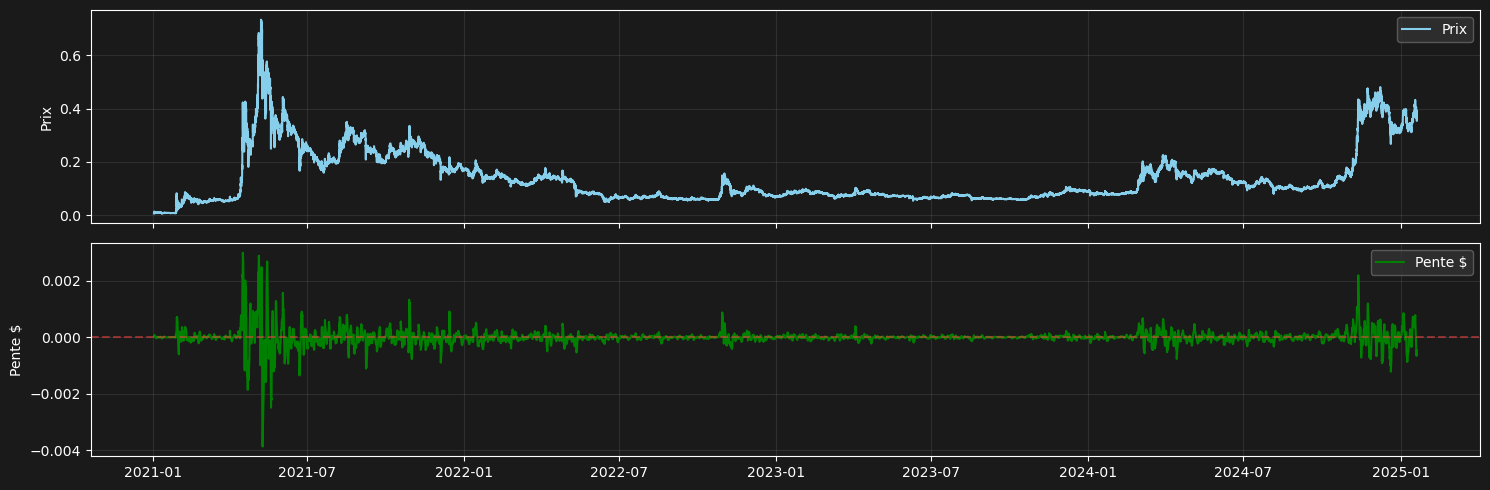

In [8]:
metrics_config = {
    'close': {'label': 'Prix', 'color': 'skyblue'},
    'slope': {'label': 'Pente $', 'color': 'green', 'zero_line': True}}

plot_metrics(df,metrics_config )

💡 Remarques :  
>❌  La pente (slope) n'est pas normalisée pour pouvoir être utilisé pour comparer plusieurs actifs (ex BTC = pente de 500$ et doge 0,0005$ ...)   
>❌  La pente est trop senssible à la volatilité, ce qui rend l'indicateur trop bruité et senssible aux faux signaux.

---
### L'indicateur part 2

🔍 C'est quoi la t-stats ?  
> t-stat = Pente (slope) avec filtre de fiabilité (Aka Erreur Standard:SE)  
>Elle mesure si une tendance est statistiquement significative ou juste du bruit.

🔍 Pourquoi c'est mieux pour nos algos ?  
>La pente seule peut être trompeuse si le marché est trop volatil.  
>La t-stat permet de filtrer les fausses tendances et de ne suivre que celles qui sont réellement exploitables.

✅ Bonus : La t-stats est normalisée, on peut comparer sa valeur entre différents actifs, même si leurs prix sont très différents.

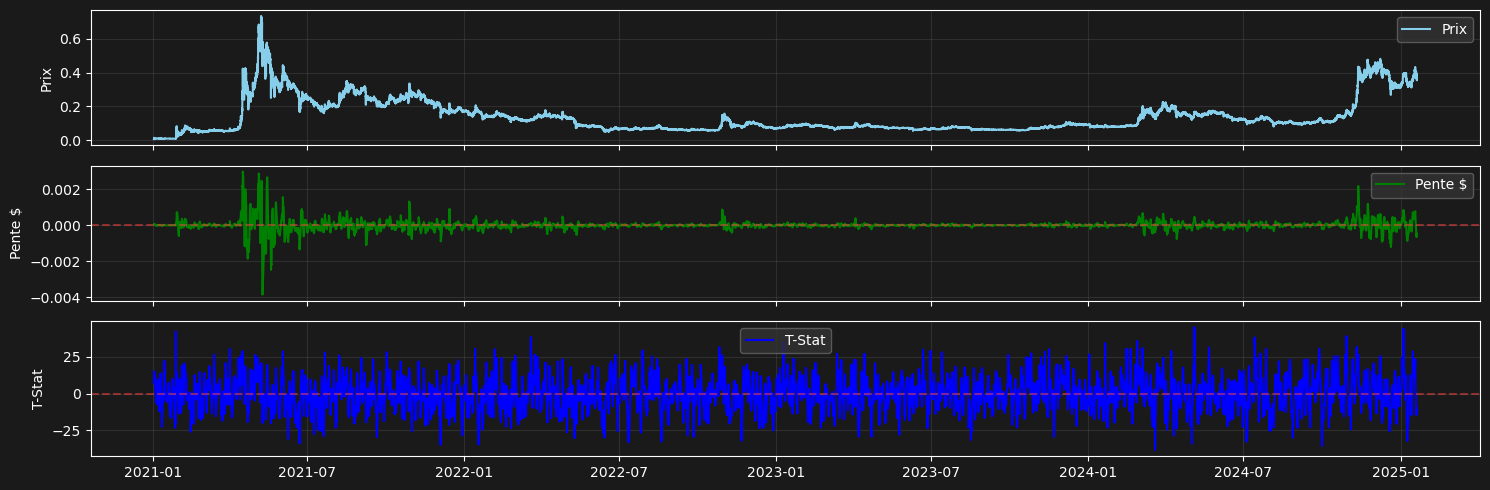

In [9]:
metrics_config = {
    'close': {'label': 'Prix', 'color': 'skyblue'},
    'slope': {'label': 'Pente $', 'color': 'green', 'zero_line': True},
    't_stat': {'label': 'T-Stat', 'color': 'blue', 'zero_line': True},
    }

plot_metrics(df,metrics_config )

---
### 📊 Affichage de l'indicateur 

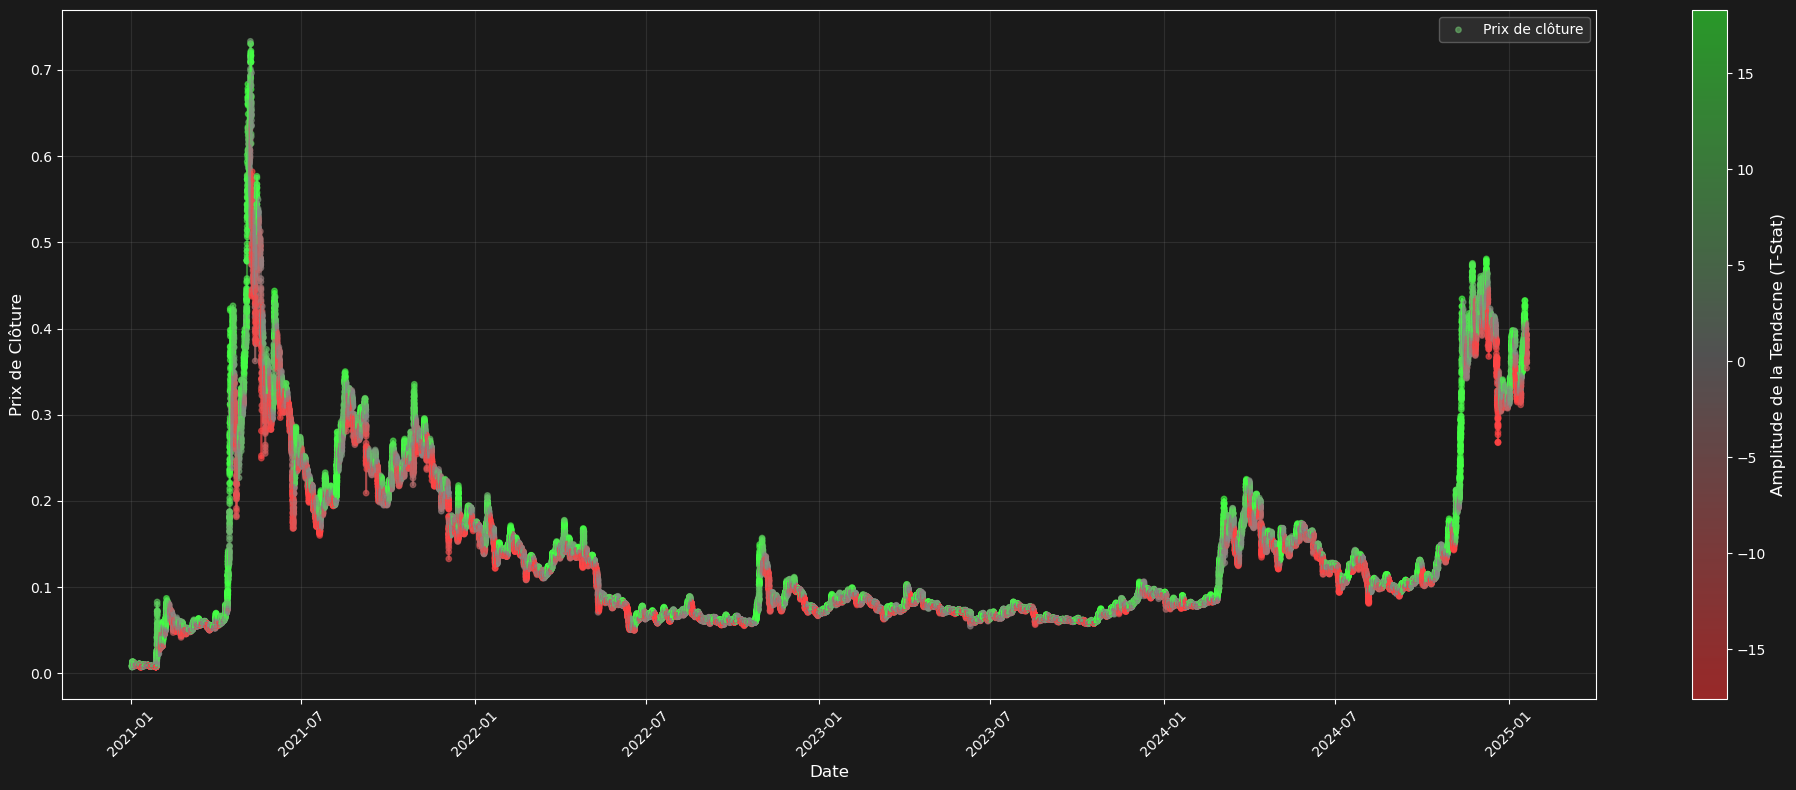

In [10]:
def plot_trend_with_colormap(df):
    # Définir le style du graphique
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(20, 8))

    # Normaliser la t_stat pour la colormap
    norm = plt.Normalize(vmin=df['t_stat'].quantile(0.05), vmax=df['t_stat'].quantile(0.95))
    # Définir une colormap personnalisée: rouge pour baisse, gris pour neutre, vert pour hausse
    colors = ['#ff4444', '#888888', '#44ff44']  # Rouge, Gris, Vert
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    # Tracer le prix de clôture avec une colormap basée sur la t_stat
    sc = ax.scatter(df.index, df['close'], c=df['t_stat'], cmap=cmap, norm=norm, s=15, alpha=0.6, label='Prix de clôture')

    # Ajouter une barre de couleur pour montrer la correspondance des couleurs avec la t_stat
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Amplitude de la Tendacne (T-Stat)', fontsize=12, color='white')
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')

    # Tracer les segments avec différentes couleurs
    dates = df.index
    close_prices = df['close'].values
    t_stats = df['t_stat'].values

    for i in range(1, len(dates)):
        color = cmap(norm(t_stats[i]))
        ax.plot([dates[i-1], dates[i]], [close_prices[i-1], close_prices[i]], color=color, linewidth=1.5, alpha=0.5)

    # Ajouter titre et étiquettes
    ax.set_title('', fontsize=16, color='white')
    ax.set_xlabel('Date', fontsize=12, color='white')
    ax.set_ylabel('Prix de Clôture', fontsize=12, color='white')
    ax.grid(alpha=0.2, color='gray')
    ax.legend(facecolor='#333333', edgecolor='#666666')

    # Formater les dates de l'axe x et le style
    plt.xticks(rotation=45, color='white')
    ax.tick_params(colors='white')
    ax.set_facecolor('#1a1a1a')
    fig.set_facecolor('#1a1a1a')

    plt.tight_layout()
    plt.show()

# affichage de l'indicateur
plot_trend_with_colormap(df)

---
🚀 On en fait quoi maintenant ?

>- Filtre pour les signaux d'un autre modèle/indicateur (ex. BBLOG)
>- Une valeur continu pour définir la taille des trades
>- Signaux de changement de régimes
>- Une entrée pour un autre modèle IA